In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
  
# SQLAlchemy connectable
cnx = create_engine('sqlite:///mta_data.db').connect()
  
# table named 'mta_data' will be returned as a dataframe.
turnstiles_df = pd.read_sql_table('mta_data', cnx)

In [2]:
turnstiles_df['YEAR'] = turnstiles_df['DATE'].str.split('/', 2, expand=True)[2]

In [3]:
# Keep March 2019, March 2020, April 2020, March 2022 data
df_c = turnstiles_df.copy()
df_03 = df_c[df_c['DATE'].str.startswith('03')] 
df_04 = df_c[df_c['DATE'].str.startswith('04')] 
df_04_2020 = df_04[df_04['DATE'].str.endswith('2020')] 
df_concat = pd.concat([df_03, df_04_2020])

In [4]:
df = df_concat.copy()

In [5]:
import datetime
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format = '%m/%d/%Y %H:%M:%S')

In [6]:
# Get rid of the duplicate entry
df.sort_values(['YEAR', 'C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'],
               inplace=True,
               ascending = False)
df.drop_duplicates(subset=['YEAR', 'C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace = True)

In [7]:
df = df.drop(['EXITS', 'DESC', 'LINENAME', 'DIVISION'], axis = 1, errors = 'ignore')

In [8]:
# Select the first entries for each date and each turnstile
df_daily = (df
            .groupby(["YEAR", "C/A", "UNIT", "SCP", "STATION", "DATE"])
            .ENTRIES.first()
            .reset_index())

In [9]:
# Calculate daily entry
temp_df = (df_daily
           .groupby(["YEAR", "C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
           .apply(lambda x: x.shift(1)))
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = temp_df[["DATE", "ENTRIES"]]
df_daily.head()

,YEAR,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,2019,A002,R051,02-00-00,59 ST,03/01/2019,6963578,NaN,NaN
1,2019,A002,R051,02-00-00,59 ST,03/02/2019,6964320,03/01/2019,6963578.0
2,2019,A002,R051,02-00-00,59 ST,03/03/2019,6964888,03/02/2019,6964320.0
3,2019,A002,R051,02-00-00,59 ST,03/04/2019,6966123,03/03/2019,6964888.0
4,2019,A002,R051,02-00-00,59 ST,03/05/2019,6967602,03/04/2019,6966123.0


In [10]:
# Drop the rows for the earliest date for each turnstile
df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [11]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


df_daily['DAILY_ENTRIES'] = df_daily.apply(get_daily_counts, axis = 1, max_counter = 1000000)

In [12]:
df_daily['MONTH'] = df_daily['DATE'].str.split('/', 2, expand=True)[0]

In [13]:
df_daily.head()

,YEAR,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,MONTH
1,2019,A002,R051,02-00-00,59 ST,03/02/2019,6964320,03/01/2019,6963578.0,742.0,03
2,2019,A002,R051,02-00-00,59 ST,03/03/2019,6964888,03/02/2019,6964320.0,568.0,03
3,2019,A002,R051,02-00-00,59 ST,03/04/2019,6966123,03/03/2019,6964888.0,1235.0,03
4,2019,A002,R051,02-00-00,59 ST,03/05/2019,6967602,03/04/2019,6966123.0,1479.0,03
5,2019,A002,R051,02-00-00,59 ST,03/06/2019,6969056,03/05/2019,6967602.0,1454.0,03


In [67]:
# combine the number with different SCP but the same station
df_daily_c = (df_daily.groupby(["YEAR", "STATION","DATE"])
                        .DAILY_ENTRIES.sum()
                        .reset_index()
                       
                       )
df_daily_c.head(5)

,YEAR,STATION,DATE,DAILY_ENTRIES
0,2019,1 AV,03/02/2019,231.0
1,2019,1 AV,03/03/2019,6.0
2,2019,1 AV,03/04/2019,15043.0
3,2019,1 AV,03/05/2019,20090.0
4,2019,1 AV,03/06/2019,21066.0


In [129]:
mask = ((df_daily_c['YEAR']=='2022')&
        (df_daily_c['STATION']=='WALL ST')
       )
mask2 = ((df_daily_c['YEAR']=='2019')&
        (df_daily_c['STATION']=='WALL ST')
       )

df_daily_c_WALL = df_daily_c[mask]
df_daily_c_WALL2 = df_daily_c[mask2]

mask3 = ((df_daily_c['DATE']!='03/14/2019')&
        (df_daily_c['DATE']!='03/26/2019')
       ) 
df_daily_c_WALL2 = df_daily_c_WALL2[mask3]


/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_14491/4101920425.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_daily_c_WALL2 = df_daily_c_WALL2[mask3]


In [147]:
mask3 = ((df_daily_c['YEAR']=='2022')&
        (df_daily_c['STATION']=='111 ST')
       )
mask4 = ((df_daily_c['YEAR']=='2019')&
        (df_daily_c['STATION']=='111 ST')
       )

df_daily_c_SIMPSON = df_daily_c[mask3]
df_daily_c_SIMPSON2 = df_daily_c[mask4]



In [148]:
import numpy as np
df_daily_c_WALL['Day_of_week_num'] = pd.to_datetime(df_daily_c_WALL['DATE']).dt.dayofweek
df_daily_c_WALL['WEEK_OF_YEAR'] = pd.to_datetime(df_daily_c_WALL['DATE']).dt.week

df_daily_c_WALL2['Day_of_week_num'] = pd.to_datetime(df_daily_c_WALL2['DATE']).dt.dayofweek
df_daily_c_WALL2['WEEK_OF_YEAR'] = pd.to_datetime(df_daily_c_WALL2['DATE']).dt.week

df_daily_c_SIMPSON['Day_of_week_num'] = pd.to_datetime(df_daily_c_SIMPSON['DATE']).dt.dayofweek
df_daily_c_SIMPSON['WEEK_OF_YEAR'] = pd.to_datetime(df_daily_c_SIMPSON['DATE']).dt.week

df_daily_c_SIMPSON2['Day_of_week_num'] = pd.to_datetime(df_daily_c_SIMPSON2['DATE']).dt.dayofweek
df_daily_c_SIMPSON2['WEEK_OF_YEAR'] = pd.to_datetime(df_daily_c_SIMPSON2['DATE']).dt.week

/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_14491/1628761263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_c_WALL['Day_of_week_num'] = pd.to_datetime(df_daily_c_WALL['DATE']).dt.dayofweek
/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_14491/1628761263.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_daily_c_WALL['WEEK_OF_YEAR'] = pd.to_datetime(df_daily_c_WALL['DATE']).dt.week
/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_14491/1628761263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

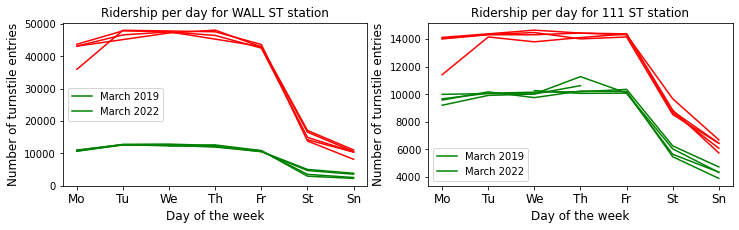

In [164]:
fig = plt.figure(figsize = (12, 3))
# 1
plt.subplot(1,2,1)
for i,  group in df_daily_c_WALL.groupby('WEEK_OF_YEAR'):
    plt.plot(group['Day_of_week_num'], group['DAILY_ENTRIES'], c = 'g')

for i,  group in df_daily_c_WALL2.groupby('WEEK_OF_YEAR'):
    plt.plot(group['Day_of_week_num'], group['DAILY_ENTRIES'], c = 'r')
   
plt.xlabel('Day of the week', fontsize = 12)
plt.ylabel('Number of turnstile entries', fontsize = 12)
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'], fontsize = 12)
plt.title('Ridership per day for WALL ST station', fontsize = 12)
plt.legend(['March 2019','March 2022'])

# 2
plt.subplot(1,2,2)
for i,  group in df_daily_c_SIMPSON.groupby('WEEK_OF_YEAR'):
    plt.plot(group['Day_of_week_num'], group['DAILY_ENTRIES'], c = 'g')

for i,  group in df_daily_c_SIMPSON2.groupby('WEEK_OF_YEAR'):
    plt.plot(group['Day_of_week_num'], group['DAILY_ENTRIES'], c = 'r')
   
plt.xlabel('Day of the week', fontsize = 12)
plt.ylabel('Number of turnstile entries', fontsize = 12)
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'], fontsize = 12)
plt.title('Ridership per day for 111 ST station', fontsize = 12)
plt.legend(['March 2019','March 2022'])

In [ ]:
fig = plt.figure(figsize = (9, 12))
#
# 1
plt.subplot(3,2,1)
plt.plot(df_all["DATE"], df_all["MONTHLY_ENTRIES_ALL"], marker='o', color = 'k')
plt.xlabel('Month of different years', fontsize = 12)
plt.ylabel('Monthly entries', fontsize = 12)
plt.xticks([0, 12, 15, 48], ['March 2019', 'March 2020', 'April 2020', 'March 2022'], rotation =90)


#2
plt.subplot(3,2,2)
plt.hist(for_plot3["ratio"], bins = 60)
plt.xlabel('Ratio of March entries in 2022 vs 2019', fontsize = 12)
plt.ylabel('Counts of stations', fontsize = 12)
plt.axvline(for_plot3["ratio"].median(), color='k', linestyle='dashed', linewidth=1)

Convert the daily entries into the monthly entries

In [14]:
# sum of the daily entries for different station in different years
df_monthly = (df_daily
                     .groupby(["STATION","YEAR","MONTH"])
                     .DAILY_ENTRIES.sum()
                     .reset_index()
                     .rename(columns={'DAILY_ENTRIES': 'MONTHLY_ENTRIES'})
           )


In [15]:
df_monthly.head()

,STATION,YEAR,MONTH,MONTHLY_ENTRIES
0,1 AV,2019,03,449584.0
1,1 AV,2020,03,196876.0
2,1 AV,2020,04,818252.0
3,1 AV,2022,03,1013208.0
4,103 ST,2019,03,782322.0


In [16]:
#sum of all stations for different monthes
df_all = (df_monthly
                     .groupby(["YEAR","MONTH"])
                     .MONTHLY_ENTRIES.sum()
                     .reset_index()
                     .rename(columns={'MONTHLY_ENTRIES': 'MONTHLY_ENTRIES_ALL'})
           )

In [17]:


df_all['DATE'] = [0, 12, 13, 48]
df_all.head()

,YEAR,MONTH,MONTHLY_ENTRIES_ALL,DATE
0,2019,03,164535189.0,0
1,2020,03,89714084.0,12
2,2020,04,16019945.0,13
3,2022,03,73741576.0,48


Compare the entries on March for different stations in 2022 vs 2019

In [18]:
# Split tables into different years and then join the tables by STATION
df_monthly_joined = pd.merge(
    df_monthly[df_monthly['YEAR']=='2019'],
    df_monthly[df_monthly['YEAR']=='2022'],
    on="STATION")
df_monthly_joined.rename(columns={'MONTHLY_ENTRIES_x': 'ENTRIES_2019',
                                  'MONTHLY_ENTRIES_y': 'ENTRIES_2022'
                                 }, inplace = True)
df_monthly_joined= df_monthly_joined[['STATION', 'ENTRIES_2019', 'ENTRIES_2022']]

df_monthly_joined.tail() 

,STATION,ENTRIES_2019,ENTRIES_2022
373,WOODLAWN,171861.0,93720.0
374,WORLD TRADE CTR,410964.0,158343.0
375,WTC-CORTLANDT,337449.0,127849.0
376,YORK ST,298033.0,110013.0
377,ZEREGA AV,65756.0,35333.0


In [19]:
df_monthly_joined['ratio'] = df_monthly_joined.ENTRIES_2022/df_monthly_joined.ENTRIES_2019
df_monthly_joined.to_csv('ratio.csv')

Add the borough for different stations into the table

In [20]:
table1 = pd.read_csv('body.csv')
table1=table1[['complex_id', 'station']]
table1.rename(columns={'complex_id': 'Complex ID',
                                  'station': 'STATION'
                                 }, inplace = True)
table1.drop_duplicates(subset=['Complex ID', 'STATION'], inplace = True)
table2 = pd.read_csv('Stations.csv')
table2=table2[['Complex ID', 'Borough']]
table_joined = pd.merge(table1,table2,
    on="Complex ID")

table_joined.drop_duplicates(subset=['STATION', 'Borough'], inplace = True)

In [21]:
table3 = pd.read_csv('ratio.csv')
df_monthly_joined = pd.merge(table_joined,table3,
    on="STATION")
df_monthly_joined.drop_duplicates(subset=['Complex ID', 'STATION', 'Borough'], inplace = True)

In [22]:
df_monthly_joined['STATION'] = df_monthly_joined['STATION']+" "+"("+df_monthly_joined['Borough']+")"

df_monthly_joined['mean'] = (df_monthly_joined['ENTRIES_2019']+df_monthly_joined['ENTRIES_2022'])/2
df_monthly_joined.head()                                                            

,Complex ID,STATION,Borough,Unnamed: 0,ENTRIES_2019,ENTRIES_2022,ratio,mean
0,635.0,SOUTH FERRY (M),M,340,391645.0,157673.0,0.402592,274659.0
1,628.0,FULTON ST (M),M,226,2352167.0,874259.0,0.371682,1613213.0
2,292.0,FULTON ST (Bk),Bk,226,2352167.0,874259.0,0.371682,1613213.0
3,86.0,CYPRESS HILLS (Bk),Bk,198,33809.0,20614.0,0.609719,27211.5
4,83.0,WOODHAVEN BLVD (Q),Q,372,623899.0,357967.0,0.573758,490933.0


visulization

In [23]:
for_plot = df_monthly_joined.sort_values('ratio').reset_index()

In [24]:
for_plot.tail(25)

,index,Complex ID,STATION,Borough,Unnamed: 0,ENTRIES_2019,ENTRIES_2022,ratio,mean
156,4,83.0,WOODHAVEN BLVD (Q),Q,372,623899.0,357967.0,0.573758,490933.0
157,51,256.0,PARSONS BLVD (Q),Q,313,173919.0,101355.0,0.582771,137637.0
158,135,221.0,21 ST (Q),Q,41,39106.0,22863.0,0.584642,30984.5
159,132,286.0,BROADWAY (Bk),Bk,164,353200.0,209179.0,0.592240,281189.5
160,25,298.0,207 ST (M),M,40,161399.0,96442.0,0.597538,128920.5
161,36,349.0,JUNIUS ST (Bk),Bk,260,56509.0,33827.0,0.598613,45168.0
162,11,616.0,74 ST-BROADWAY (Q),Q,99,85074.0,50986.0,0.599314,68030.0
163,118,383.0,183 ST (Bx),Bx,35,145246.0,88438.0,0.608884,116842.0
164,3,86.0,CYPRESS HILLS (Bk),Bk,198,33809.0,20614.0,0.609719,27211.5
165,26,297.0,215 ST (M),M,43,45940.0,28165.0,0.613082,37052.5


In [151]:
for_plot2 = for_plot.iloc[2:178]
for_plot3 = for_plot2.reset_index()
for_plot3

,level_0,index,Complex ID,STATION,Borough,Unnamed: 0,ENTRIES_2019,ENTRIES_2022,ratio,mean
0,2,125,177.0,CLINTON-WASH AV (Bk),Bk,189,1171069.0,128578.0,0.109795,649823.5
1,3,61,273.0,QUEENS PLAZA (Q),Q,324,1208901.0,152391.0,0.126057,680646.0
2,4,66,314.0,66 ST-LINCOLN (M),M,91,1377287.0,237869.0,0.172708,807578.0
3,5,17,333.0,WALL ST (M),M,365,1296801.0,289168.0,0.222986,792984.5
4,6,50,165.0,23 ST (M),M,46,4079559.0,1073909.0,0.263241,2576734.0
...,...,...,...,...,...,...,...,...,...,...
171,173,71,38.0,86 ST (Bk),Bk,110,2161977.0,1454182.0,0.672617,1808079.5
172,174,23,306.0,125 ST (M),M,9,2081050.0,1405547.0,0.675403,1743298.5
173,175,128,242.0,FT HAMILTON PKY (Bk),Bk,225,334770.0,238142.0,0.711360,286456.0
174,176,6,81.0,111 ST (Q),Q,5,357982.0,262565.0,0.733459,310273.5


In [159]:
Top_down = for_plot3[for_plot3['ratio']<=0.329]
Top_up = for_plot3[for_plot3['ratio']>=0.628]
Top_up


,level_0,index,Complex ID,STATION,Borough,Unnamed: 0,ENTRIES_2019,ENTRIES_2022,ratio,mean
166,168,56,452.0,90 ST-ELMHURST (Q),Q,114,417130.0,262050.0,0.628221,339590.0
167,169,79,395.0,103 ST (M),M,1,782322.0,497971.0,0.636529,640146.5
168,170,164,70.0,BAY 50 ST (Bk),Bk,136,69049.0,44082.0,0.638416,56565.5
169,171,92,450.0,103 ST-CORONA (Q),Q,2,506560.0,325303.0,0.642181,415931.5
170,172,70,311.0,86 ST (M),M,110,2161977.0,1454182.0,0.672617,1808079.5
171,173,71,38.0,86 ST (Bk),Bk,110,2161977.0,1454182.0,0.672617,1808079.5
172,174,23,306.0,125 ST (M),M,9,2081050.0,1405547.0,0.675403,1743298.5
173,175,128,242.0,FT HAMILTON PKY (Bk),Bk,225,334770.0,238142.0,0.711360,286456.0
174,176,6,81.0,111 ST (Q),Q,5,357982.0,262565.0,0.733459,310273.5
175,177,115,629.0,LORIMER ST (Bk),Bk,275,262425.0,239382.0,0.912192,250903.5


In [160]:
Top_down

,level_0,index,Complex ID,STATION,Borough,Unnamed: 0,ENTRIES_2019,ENTRIES_2022,ratio,mean
0,2,125,177.0,CLINTON-WASH AV (Bk),Bk,189,1171069.0,128578.0,0.109795,649823.5
1,3,61,273.0,QUEENS PLAZA (Q),Q,324,1208901.0,152391.0,0.126057,680646.0
2,4,66,314.0,66 ST-LINCOLN (M),M,91,1377287.0,237869.0,0.172708,807578.0
3,5,17,333.0,WALL ST (M),M,365,1296801.0,289168.0,0.222986,792984.5
4,6,50,165.0,23 ST (M),M,46,4079559.0,1073909.0,0.263241,2576734.0
5,7,33,339.0,BERGEN ST (Bk),Bk,152,556607.0,161143.0,0.289509,358875.0
6,8,72,602.0,14 ST-UNION SQ (M),M,14,3236694.0,938202.0,0.289864,2087448.0
7,9,31,612.0,51 ST (M),M,79,512223.0,154382.0,0.301396,333302.5
8,10,129,324.0,HOUSTON ST (M),M,242,372885.0,120075.0,0.322016,246480.0
9,11,12,609.0,42 ST-BRYANT PK (M),M,67,1020204.0,334931.0,0.328298,677567.5


In [161]:
for_plot3['ratio'].describe()

count    176.000000
mean       0.466173
std        0.107443
min        0.109795
25%        0.400469
50%        0.469435
75%        0.528935
max        0.912192
Name: ratio, dtype: float64

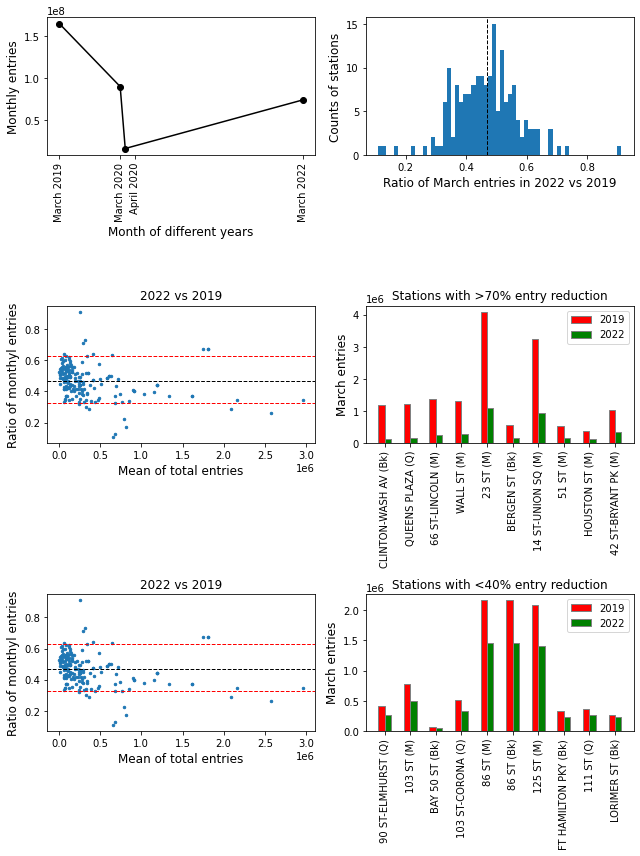

In [165]:
import numpy as np


# set width of bar
barWidth = 0.25

 
# set height of bar
E_19 = Top_down['ENTRIES_2019']
E_22 = Top_down['ENTRIES_2022']

E_19_up = Top_up['ENTRIES_2019']
E_22_up = Top_up['ENTRIES_2022']

 
# Set position of bar on X axis
br1 = np.arange(len(E_19))
br2 = [x + barWidth for x in br1]

 
# Make the plot
#
 
fig = plt.figure(figsize = (9, 12))
#
# 1
plt.subplot(3,2,1)
plt.plot(df_all["DATE"], df_all["MONTHLY_ENTRIES_ALL"], marker='o', color = 'k')
plt.xlabel('Month of different years', fontsize = 12)
plt.ylabel('Monthly entries', fontsize = 12)
plt.xticks([0, 12, 15, 48], ['March 2019', 'March 2020', 'April 2020', 'March 2022'], rotation =90)


#2
plt.subplot(3,2,2)
plt.hist(for_plot3["ratio"], bins = 60)
plt.xlabel('Ratio of March entries in 2022 vs 2019', fontsize = 12)
plt.ylabel('Counts of stations', fontsize = 12)
plt.axvline(for_plot3["ratio"].median(), color='k', linestyle='dashed', linewidth=1)
#3
plt.subplot(3,2,3)
plt.scatter(for_plot3['mean'], for_plot3["ratio"], s = 6)
plt.title('2022 vs 2019')
plt.xlabel('Mean of total entries', fontsize = 12)
plt.ylabel('Ratio of monthyl entries', fontsize = 12)
plt.axhline(for_plot3["ratio"].median(), color='k', linestyle='dashed', linewidth=1)
plt.axhline(0.329, color='r', linestyle='dashed', linewidth=1)
plt.axhline(0.63, color='r', linestyle='dashed', linewidth=1)
#
plt.subplot(3,2,4)
plt.bar(br1, E_19, color ='r', width = barWidth,
        edgecolor ='grey', label ='IT')
plt.bar(br2, E_22, color ='g', width = barWidth,
        edgecolor ='grey', label ='ECE')
list_S = [Top_down['STATION']]


plt.ylabel('March entries', fontsize = 12)
plt.xticks([r + barWidth/2 for r in range(10)], Top_down['STATION'].tolist(), rotation = 90)
plt.legend(['2019','2022'])
plt.title('Stations with >70% entry reduction')
#5
plt.subplot(3,2,5)
plt.scatter(for_plot3['mean'], for_plot3["ratio"], s = 6)
plt.title('2022 vs 2019')
plt.xlabel('Mean of total entries', fontsize = 12)
plt.ylabel('Ratio of monthyl entries', fontsize = 12)
plt.axhline(for_plot3["ratio"].median(), color='k', linestyle='dashed', linewidth=1)
plt.axhline(0.329, color='r', linestyle='dashed', linewidth=1)
plt.axhline(0.63, color='r', linestyle='dashed', linewidth=1)
#6
plt.subplot(3,2,6)
plt.bar(br1, E_19_up, color ='r', width = barWidth,
        edgecolor ='grey', label ='IT')
plt.bar(br2, E_22_up, color ='g', width = barWidth,
        edgecolor ='grey', label ='ECE')
list_S_up = [Top_up['STATION']]

plt.ylabel('March entries', fontsize = 12)
plt.xticks([r + barWidth/2 for r in range(10)], Top_up['STATION'].tolist(), rotation = 90)
plt.legend(['2019','2022'])
plt.title('Stations with <40% entry reduction')
fig.tight_layout()

plt.savefig('/Users/chioun/desktop/metis_data_camp/MTA/image6.jpg')